In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [3]:
trainset = datasets.FashionMNIST('./.data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c] , 1)
        return self.model(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )        
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [7]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002)

In [8]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print("EPOCH [{}/{}] D_Loss:{:.4f} G_Loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}".format(epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

EPOCH [0/300] D_Loss:0.2403 G_Loss: 4.1071 D(x):0.91 D(G(z)):0.10
EPOCH [1/300] D_Loss:0.3733 G_Loss: 3.8627 D(x):0.89 D(G(z)):0.13
EPOCH [2/300] D_Loss:0.2325 G_Loss: 4.7050 D(x):0.93 D(G(z)):0.09
EPOCH [3/300] D_Loss:0.3046 G_Loss: 4.0621 D(x):0.91 D(G(z)):0.10
EPOCH [4/300] D_Loss:0.2753 G_Loss: 4.3986 D(x):0.87 D(G(z)):0.04
EPOCH [5/300] D_Loss:0.3834 G_Loss: 2.8047 D(x):0.89 D(G(z)):0.15
EPOCH [6/300] D_Loss:0.4950 G_Loss: 2.5191 D(x):0.85 D(G(z)):0.19
EPOCH [7/300] D_Loss:0.7559 G_Loss: 2.7569 D(x):0.79 D(G(z)):0.18
EPOCH [8/300] D_Loss:0.6375 G_Loss: 2.3447 D(x):0.78 D(G(z)):0.16
EPOCH [9/300] D_Loss:0.6730 G_Loss: 2.2048 D(x):0.88 D(G(z)):0.27
EPOCH [10/300] D_Loss:0.5994 G_Loss: 2.5295 D(x):0.79 D(G(z)):0.15
EPOCH [11/300] D_Loss:1.1211 G_Loss: 1.5002 D(x):0.67 D(G(z)):0.33
EPOCH [12/300] D_Loss:0.9682 G_Loss: 1.6342 D(x):0.73 D(G(z)):0.30
EPOCH [13/300] D_Loss:0.7677 G_Loss: 1.6688 D(x):0.73 D(G(z)):0.25
EPOCH [14/300] D_Loss:0.8907 G_Loss: 1.7458 D(x):0.69 D(G(z)):0.28
EPOCH

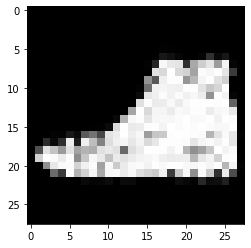

In [10]:
item_number = 9
z = torch.randn(1, 100).to(DEVICE)
g_label = torch.full((1, ), item_number, dtype = torch.long).to(DEVICE)
sample_images = G(z, g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0], (28, 28))

plt.imshow(sample_images_img, cmap = 'gray')
plt.show()